# NDVI

The first index to calculate is the Normalized Difference Vegetation Index (NDVI).
It is an index that uses plant reflectivity in the infra-red spectrum and allows drawing conclusions on different plant types, vegetation health or surface condition.
It can be calculated from Sentinel-2 data using the red and infra-red spectra (bands 4 and 8):

$$
\text{NDVI} = \frac{\text{B08} - \text{B04}}{\text{B08} + \text{B04}}
$$

In [1]:
import geopandas as gpd
from pathlib import Path
from sentinel_helpers import scihub_band_paths

base_path = Path('resources/tempelhofer_feld')
product_path = sorted(base_path.glob('*.zip'))[14]
output_path = base_path / 'ndvi'
output_path.mkdir(exist_ok=True, parents=True)

tempelhofer_feld = gpd.read_file(base_path / 'tempelhofer_feld.geojson')

b04_path, b08_path = scihub_band_paths(product_path, ['B04', 'B08'], '10m')
b04_path, b08_path

(PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20190825T102031_N0213_R065_T33UUU_20190825T134836.zip!/S2A_MSIL2A_20190825T102031_N0213_R065_T33UUU_20190825T134836.SAFE/GRANULE/L2A_T33UUU_A021798_20190825T102430/IMG_DATA/R10m/T33UUU_20190825T102031_B04_10m.jp2'),
 PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20190825T102031_N0213_R065_T33UUU_20190825T134836.zip!/S2A_MSIL2A_20190825T102031_N0213_R065_T33UUU_20190825T134836.SAFE/GRANULE/L2A_T33UUU_A021798_20190825T102430/IMG_DATA/R10m/T33UUU_20190825T102031_B08_10m.jp2'))

Because the indices get distorted by clouds, the cloud pixels have to be masked out.
The product downloads include a raster files with information about cloud probability of individual pixels and the `sentinel_helpers` module includes a helper function which constructs a boolean cloud mask from this information, optionally restricted to a given area:

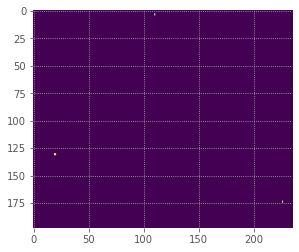

In [2]:
import matplotlib.pyplot as plt
from sentinel_helpers import scihub_cloud_mask

cloud_mask, _ = scihub_cloud_mask(product_path, area=tempelhofer_feld)
plt.imshow(cloud_mask[0])

The actual indexed calculation can be easily expressed using `numpy` arrays thanks to operator overloading which implements [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html): For two arrays `array_a` and `array_b` with identical shapes, `array_a + array_b` adds each cell in `array_a` with the corresponding cell in `array_b`. `b04 + b08` therefore does a pixel-wise addition for each pixel in `b04` and `b08`.

The product, which is much larger than only the designated area of interest, is masked an cropped, and the index is calculated. The mask is modified so that cloud pixels are masked out as well.

EPSG:32633
CPU times: user 1.35 s, sys: 94.8 ms, total: 1.45 s
Wall time: 538 ms


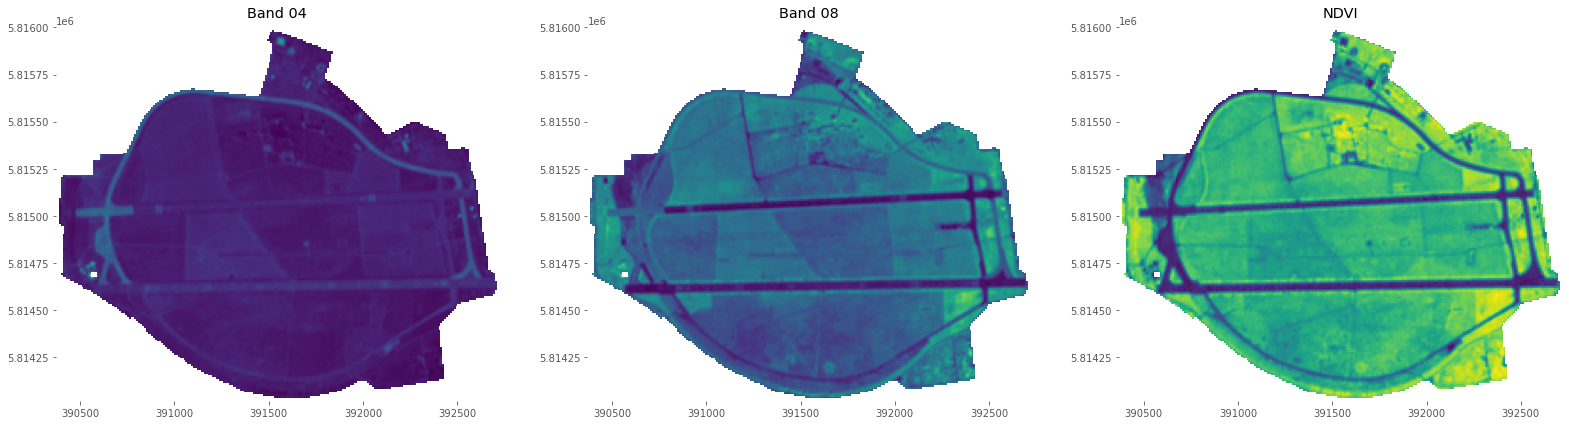

In [3]:
%%time

import numpy as np
import rasterio as r
import rasterio.mask
import rasterio.plot as rplt
from rasterio.features import geometry_window

def normalize(v):
    '''
    Normalizes Sentinel-2 DN numbers to reflectance values ranging from 0 to 1
    and clips values outside of the allowed range.
    '''
    return (np.clip(v, 0, 10_000) / 10_000).astype('f4') # ← four-byte-float / float32

with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
    print(b04.crs)
    
    # we want to only write the bare minimum data necessary to disk
    out_meta = b04.meta.copy()
    
    # we reproject the geojson file we fetched above and convert it so that rasterio
    # can use it as a mask
    mask = tempelhofer_feld.to_crs(out_meta['crs']).iloc[0]['geometry']
    window = geometry_window(b04, [mask])
    
    # update the dimensions and save as geotiff, not jp2
    out_meta.update({
        'width': window.width,
        'height': window.height,
        'driver': 'GTiff',
        'dtype': 'float32'
    })    
    out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')
    
    output_file = output_path / out_name
    with r.open(output_file, 'w+', **out_meta) as dst:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
        
        # hide background grid in plot
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        
        # we take only the part out of our source raster that we actually need
        # crop=True clips off the borders
        b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], filled=False, crop=True)
        b08, _ = rasterio.mask.mask(b08, shapes=[mask], filled=False, crop=True) # we ignore the returned transform because it's identical to the previous one
        
        # mask clouds and make sure that cloud_masks have the exact same shape
        # as the raster files, because it can happen that when upsampling the
        # cloud mask they don't match exactly
        cloud_mask = cloud_mask[:,:b04.shape[1],:b04.shape[2]]
        
        b04.mask = b04.mask | cloud_mask
        b08.mask = b08.mask | cloud_mask
        
        b04 = normalize(b04)
        b08 = normalize(b08)
        
        # while unlikely to happen, we ignore divide by zero errors when they occur
        np.seterr(divide='ignore', invalid='ignore')
        ndvi = (b08 - b04) / (b08 + b04)
       
        # uncomment the following line to see if we calculated the index correctly
        rplt.show(b04, transform=transform_b04, ax=ax1)
        ax1.set_title('Band 04', pad=10)
        rplt.show(b08, transform=transform_b04, ax=ax2)
        ax2.set_title('Band 08', pad=10)
        rplt.show(ndvi, transform=transform_b04, ax=ax3)
        ax3.set_title('NDVI', pad=10)
        
        dst.write(ndvi)

> Calculations of NDVI for a given pixel always result in a number that ranges from minus one (-1) to plus one (+1); however, no green leaves gives a value close to zero. A zero means no vegetation and close to +1 (0.8 - 0.9) indicates the highest possible density of green leaves.

Source: [NASA Earth Observatory](https://www.earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php)

These properties can be shown when looking at different sections of the area:

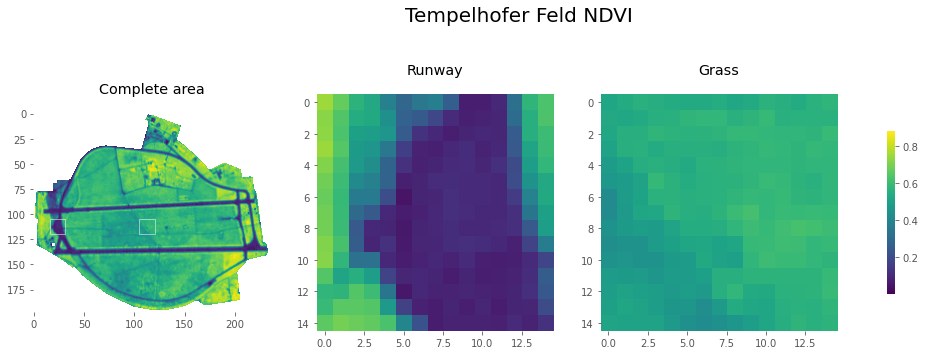

In [4]:
# draw rectangles on ndvi plot
import matplotlib.patches as patches

fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle('Tempelhofer Feld NDVI', fontsize=20)

# hide background grid
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

# use same color scale for all plots
vmin = ndvi.min()
vmax = ndvi.max()

# plot ndvi first
axs[0].imshow(ndvi[0])

# mark different areas on first plot
runway = patches.Rectangle((16, 105), 15, 15, facecolor='none', edgecolor='white')
grass = patches.Rectangle((105, 105), 15, 15, facecolor='none', edgecolor='white')

axs[0].add_patch(runway)
axs[0].add_patch(grass)
axs[0].set_title('Complete area', pad=20)

# use array indexing to plot the areas marked by the rectangles
# indices are z,y,x
runway_extracted = ndvi[0,105:120,16:31] 
axs[1].imshow(runway_extracted, vmin=vmin, vmax=vmax)
axs[1].set_title('Runway', pad=20)

grass_extracted = ndvi[0,105:120,105:120]
im = axs[2].imshow(grass_extracted, vmin=vmin, vmax=vmax)
axs[2].set_title('Grass', pad=20)

# add color bar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

plt.savefig(base_path / '../ndvi_detail.png', bbox_inches='tight', dpi=300)

The average NDVI of the runway is positioned towards the lower end of the scale, while the part that is covered by grass tends towards higher values:

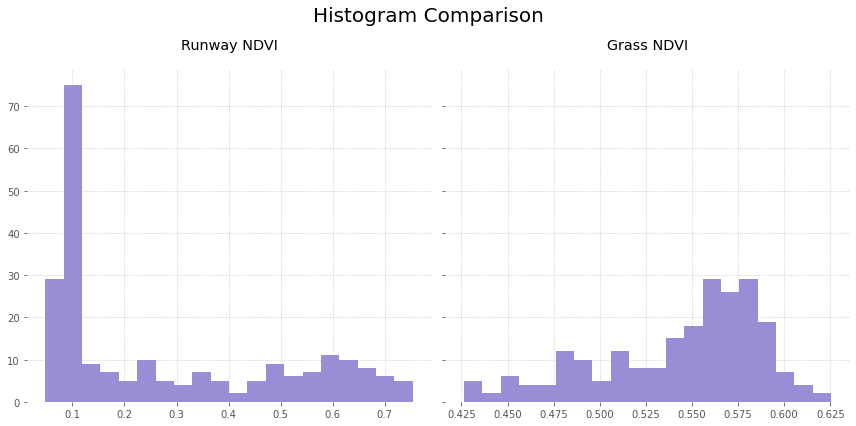

In [5]:
bins=20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(12,6))
fig.suptitle('Histogram Comparison', fontsize=20)

axs[0].hist(runway_extracted.flatten(), bins=bins)
axs[0].set_title('Runway NDVI', pad=20)

axs[1].hist(grass_extracted.flatten(), bins=bins)
axs[1].set_title('Grass NDVI', pad=20)

plt.savefig(base_path / '../ndvi_histogram.png', bbox_inches='tight', dpi=300)

In [15]:
np.median(grass_extracted.compressed().flatten())

0.5576989